So synthetic data has been made by me . So our first step is to identify noise in the dataset and applying techniques to remove that noise . Here I am also going to explain you each step in detail by maintaining the sequence 


Step 1 : Identifying noise in the Data

1. Random Spiked - Sudden , unrealistic step count . Eg:pet shakes the device . 
2. Missing Data - Gaps may be due to transmission error ,etc
3. Sensor Drift - Gradual over/under-counting of steps.
4. Heart Rate - Unrealistic heart rate counting .
5. Activity Mislabeling - Incorrect activity type . For eg:"running" when pet is resting 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('synthetic_pet_activity_with_noise.csv')
df.head()

,timestamp,steps,activity_type,heart_rate
0,2023-01-01 00:00:00,1.0,light_activity,105
1,2023-01-01 00:01:00,2.0,light_activity,110
2,2023-01-01 00:02:00,1.0,light_activity,103
3,2023-01-01 00:03:00,1.0,light_activity,108
4,2023-01-01 00:04:00,0.0,resting,75


In [3]:
df.isnull().sum()

timestamp          0
steps            207
activity_type      0
heart_rate         0
dtype: int64

In [4]:
df.shape

(10080, 4)

Handling Missing Data 
So there can be many solutions for this , below are mentioned two of them :
1. Simply drop the rows , but in this we have to take care that the rows to be droped are less than 5% of the dataset rows.
2. In this we can use above , but forward fill will be more better taking care that pet's activity did not change abruptly 

In [5]:
# Forward-fill missing steps 
df["steps"] = df["steps"].fillna(method="ffill")

/var/folders/v8/7sm4tkys03j44j2vkrx2myy00000gn/T/ipykernel_2090/1511352358.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["steps"] = df["steps"].fillna(method="ffill")


In [6]:
df.isnull().sum()

timestamp        0
steps            0
activity_type    0
heart_rate       0
dtype: int64

In [7]:
df = df.dropna()
#Just applied I know it is of no use

2. Smoothing Random Spikes

Problem: Sudden, unrealistic step counts.

Solution: Use a rolling median  or low-pass filter.

In [8]:
# Apply rolling median (window=5 minutes)
df["steps_cleaned"] = df["steps"].rolling(window=5, center=True).median()

# Fill edge NaN values (due to rolling window)
df["steps_cleaned"] = df["steps_cleaned"].fillna(df["steps"])

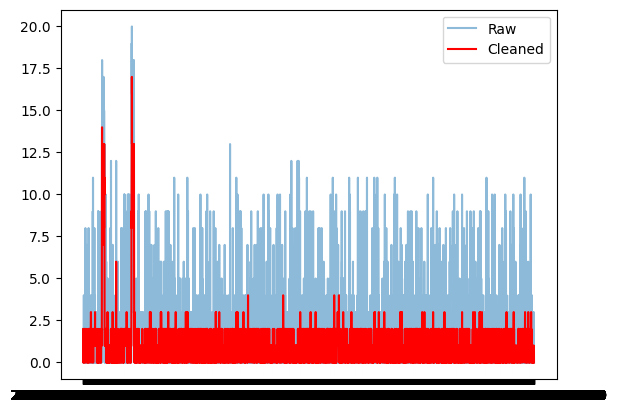

In [9]:
# Visualizing the data

import matplotlib.pyplot as plt
plt.plot(df["timestamp"], df["steps"], label="Raw", alpha=0.5)
plt.plot(df["timestamp"], df["steps_cleaned"], label="Cleaned", color="red")
plt.legend()
plt.show()

3. Correcting Sensor Drift

Problem: Step counts gradually increase/decrease over time.


Solution:

Detrending: Subtract a rolling average to remove drift.

Reset baseline: Assume the pet’s true resting step count is 0.


In [10]:
# Calculate rolling mean (window=1 day to capture drift)
drift = df["steps"].rolling(window=24*60).mean()

# Subtract drift and clip negative values to 0
df["steps_detrended"] = (df["steps"] - drift).clip(lower=0)

4. Fixing Heart Rate Artifacts

Problem: Impossible heart rates (e.g., 200 bpm at rest).

Solution:

Clip values to physiological ranges (60–120 bpm for pets).
Smooth with a rolling average.

In [11]:
# Clip unrealistic values
df["heart_rate"] = df["heart_rate"].clip(60, 120)

# Smooth with rolling mean
df["heart_rate_cleaned"] = df["heart_rate"].rolling(window=5).mean()

5. Correcting Activity Mislabeling

Problem: activity_type conflicts with steps .

Solution:Re-label activities based on step thresholds

In [12]:
# Re-label activities
df["activity_type_cleaned"] = np.where(
    df["steps"] == 0, "resting",
    np.where(df["steps"] <= 5, "light_activity", "active")
)

Step 3: Final Preprocessing

After cleaning, ensure the data is normalized and ready for ML:

In [13]:
# Normalize step count
# Min-max scaling (optional)
# Min-max scaling (optional)
df["steps_normalized"] = (df["steps_cleaned"] - df["steps_cleaned"].min()) / (df["steps_cleaned"].max() - df["steps_cleaned"].min())


2. Feature Engineering

Extract time-based features to help the model:

In [14]:
df["timestamp"] = pd.to_datetime(df["timestamp"])  # Convert to datetime
df["hour"] = df["timestamp"].dt.hour  # Extract hour
df["day_of_week"] = df["timestamp"].dt.dayofweek  # Extract day of the week


Step 4: Validate Cleaned Data

Check distributions and correlations:

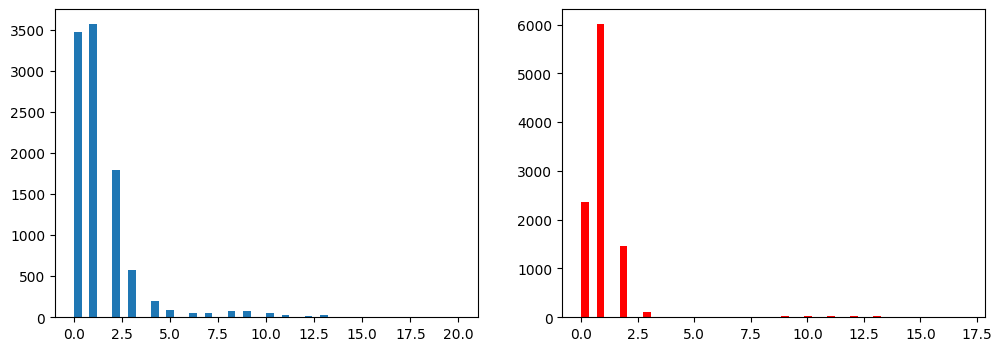

activity_type_cleaned
light_activity    6216
resting           3471
active             393
Name: count, dtype: int64


In [15]:
# Plot cleaned steps vs. raw steps
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df["steps"], bins=50, label="Raw")
plt.subplot(1, 2, 2)
plt.hist(df["steps_cleaned"], bins=50, label="Cleaned", color="red")
plt.show()

# Check activity labels
print(df["activity_type_cleaned"].value_counts())

In [16]:
df.head()

,timestamp,steps,activity_type,heart_rate,steps_cleaned,steps_detrended,heart_rate_cleaned,activity_type_cleaned,steps_normalized,hour,day_of_week
0,2023-01-01 00:00:00,1.0,light_activity,105,1.0,NaN,NaN,light_activity,0.058824,0,6
1,2023-01-01 00:01:00,2.0,light_activity,110,2.0,NaN,NaN,light_activity,0.117647,0,6
2,2023-01-01 00:02:00,1.0,light_activity,103,1.0,NaN,NaN,light_activity,0.058824,0,6
3,2023-01-01 00:03:00,1.0,light_activity,108,1.0,NaN,NaN,light_activity,0.058824,0,6
4,2023-01-01 00:04:00,0.0,resting,75,1.0,NaN,100.2,resting,0.058824,0,6


In [17]:
df.columns

Index(['timestamp', 'steps', 'activity_type', 'heart_rate', 'steps_cleaned',
       'steps_detrended', 'heart_rate_cleaned', 'activity_type_cleaned',
       'steps_normalized', 'hour', 'day_of_week'],
      dtype='object')

In [18]:
#So now I only have to keep relevant columns , rest of the columns I will drop 

final_columns = [
    "timestamp",
    "steps_cleaned",
    "heart_rate_cleaned",
    "hour",
    "day_of_week",
    "activity_type_cleaned"
]
df_cleaned = df[final_columns].copy()


In [19]:
print(df_cleaned[["steps_cleaned", "heart_rate_cleaned"]].corr())

                    steps_cleaned  heart_rate_cleaned
steps_cleaned            1.000000            0.217259
heart_rate_cleaned       0.217259            1.000000


In [20]:
df_cleaned.sample()

,timestamp,steps_cleaned,heart_rate_cleaned,hour,day_of_week,activity_type_cleaned
4058,2023-01-03 19:38:00,1.0,101.2,19,1,light_activity


In [21]:
df_cleaned['activity_type_cleaned'].value_counts()

activity_type_cleaned
light_activity    6216
resting           3471
active             393
Name: count, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_cleaned["activity_label"] = le.fit_transform(df_cleaned["activity_type_cleaned"])

In [24]:
df_cleaned.sample(9)

,timestamp,steps_cleaned,heart_rate_cleaned,hour,day_of_week,activity_type_cleaned,activity_label
1343,2023-01-01 22:23:00,0.0,79.6,22,6,light_activity,1
7736,2023-01-06 08:56:00,0.0,82.2,8,4,light_activity,1
8017,2023-01-06 13:37:00,1.0,92.0,13,4,light_activity,1
7046,2023-01-05 21:26:00,2.0,97.6,21,3,active,0
1452,2023-01-02 00:12:00,1.0,108.4,0,0,light_activity,1
4356,2023-01-04 00:36:00,1.0,93.2,0,2,light_activity,1
327,2023-01-01 05:27:00,1.0,88.6,5,6,light_activity,1
4387,2023-01-04 01:07:00,0.0,80.4,1,2,resting,2
3798,2023-01-03 15:18:00,0.0,88.2,15,1,light_activity,1


In [25]:
import pickle
with open("label.pkl","wb") as file:
    pickle.dump(le,file) 

In [26]:
df_cleaned.isnull().sum()

timestamp                0
steps_cleaned            0
heart_rate_cleaned       4
hour                     0
day_of_week              0
activity_type_cleaned    0
activity_label           0
dtype: int64

In [29]:
df_cleaned['heart_rate_cleaned'] = df['heart_rate_cleaned'].fillna(method = "bfill")

/var/folders/v8/7sm4tkys03j44j2vkrx2myy00000gn/T/ipykernel_2090/1449788797.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned['heart_rate_cleaned'] = df['heart_rate_cleaned'].fillna(method = "bfill")


In [30]:
df_cleaned.isnull().sum()

timestamp                0
steps_cleaned            0
heart_rate_cleaned       0
hour                     0
day_of_week              0
activity_type_cleaned    0
activity_label           0
dtype: int64

In [31]:
df_cleaned.to_csv("cleaned_pet_activity_data.csv", index=False)